In [33]:
from lib import *

def compute_total_amount_1(row, is_green_taxi=False):
    # Extract relevant data from the row
    trip_distance = row['trip_distance']
    pu_location_id = row['pu_location_id']
    do_location_id = row['do_location_id']
    pickup_datetime = row['pickup_datetime']
    tip_amount = row['tip_amount']
    tolls_amount = row['tolls_amount']
    congestion_surcharge = row['congestion_surcharge']
    
    # Base initial fare
    total_amount = 3.00

    # Calculate distance charge (70 cents per 1/5 mile, or 3.50 per mile)
    total_amount += (trip_distance * 3.50)
    
    # Add MTA State Surcharge of 50 cents (assuming trip ends in NYC or designated counties)
    total_amount += 0.50
    
    # Add Improvement Surcharge
    total_amount += 1.00
    
    # Time-based charges (check for overnight or rush hour surcharges)
    pickup_time = datetime.datetime.strptime(pickup_datetime, '%Y-%m-%d %H:%M:%S.%f')

    # Add $1.00 overnight surcharge (8pm to 6am)
    if pickup_time.hour >= 20 or pickup_time.hour < 6:
        total_amount += 1.00
    
    # Add $2.50 rush hour surcharge (4pm to 8pm on weekdays, excluding holidays)
    if pickup_time.weekday() < 5 and 16 <= pickup_time.hour < 20:  # Monday to Friday
        total_amount += 2.50
    
    # Here, ideally we would like to know if the ride was shared, but as we lack this information, 
    # we are assuming that all rides are not shared.
    # if is_shared_ride:
    #     total_amount += 0.75  # Shared ride surcharge
    if is_green_taxi:
        total_amount += 2.75  # Green taxi surcharge
    else:
        total_amount += 2.50  # Yellow taxi surcharge
    
    # Add tips and tolls
    total_amount += tip_amount + tolls_amount

    # Add any congestion surcharge that is directly passed in (from the row)
    if congestion_surcharge:
        total_amount += congestion_surcharge
    
    return total_amount


def getManhattanLocIds():
    df = getDF(text(f'select location_id from taxi_zones where location_name=\'Manhattan\''))
    return list(df['location_id'])

manh_locids = getManhattanLocIds()

def getLocationName(location_id):
    # airport location ids = newark=1, JFK Airport,132, LaGuardia Airport,138
    if location_id==1:
        return 'EWR'
    elif location_id==132:
        return 'JFK'
    elif location_id==138:
        return 'LGA'
    elif location_id in manh_locids:
        return 'Manhattan'
    return '-'

def compute_total_amount(row, is_green_taxi=False):
    trip_distance = row['trip_distance']
    pickup_datetime = row['pickup_datetime']
    tip_amount = row['tip_amount']
    tolls_amount = row['tolls_amount']
    congestion_surcharge = row['congestion_surcharge']
    pickup_location = getLocationName(row['pu_location_id'])
    dropoff_location = getLocationName(row['do_location_id'])
    
    # Initial base fare
    total_amount = 3.00
    
    # Metered fare: 70 cents per 1/5 mile (3.50 per mile)
    total_amount += (trip_distance * 3.50)
    
    # MTA State Surcharge
    total_amount += 0.50
    
    # Improvement Surcharge
    total_amount += 1.00
    
    # Time-based surcharges
    pickup_time = datetime.datetime.strptime(pickup_datetime, '%Y-%m-%d %H:%M:%S.%f')

    # Overnight surcharge: $1.00 (8pm to 6am)
    if pickup_time.hour >= 20 or pickup_time.hour < 6:
        total_amount += 1.00
    
    # Rush hour surcharge: $2.50 (4pm to 8pm on weekdays, excluding holidays)
    if pickup_time.weekday() < 5 and 16 <= pickup_time.hour < 20:
        total_amount += 2.50
    
    # Airport rules
    if pickup_location in ['LGA', 'JFK', 'EWR'] or dropoff_location in ['LGA', 'JFK', 'EWR']:
        
        # Handle LaGuardia (LGA)
        if pickup_location == 'LGA':
            total_amount += 1.75  # Airport Access Fee for pickup at LGA
            total_amount += 5.00  # Additional $5 surcharge for trips from/to LGA
        
        # Handle JFK Airport
        if pickup_location == 'JFK' or dropoff_location == 'JFK':
            if pickup_location == 'Manhattan' or dropoff_location == 'Manhattan':
                # Flat rate for trips between Manhattan and JFK
                total_amount = 70.00  # Flat rate
                total_amount += 0.50  # MTA Surcharge
                total_amount += 1.00  # Improvement Surcharge
                
                # Rush hour surcharge: $5.00 (4pm to 8pm weekdays)
                if pickup_time.weekday() < 5 and 16 <= pickup_time.hour < 20:
                    total_amount += 2.50
                
                # Set on-screen rate to "Rate #2 - JFK Airport"
                # print("Rate #2 - JFK Airport")
        
        # Handle Newark (EWR)
        if pickup_location == 'EWR' or dropoff_location == 'EWR':
            total_amount += 20.00  # Newark Surcharge
            total_amount += tolls_amount  # Include tolls
            
            # Set on-screen rate to "Rate #3 - Newark Airport"
            # print("Rate #3 - Newark Airport")
    
    # Congestion surcharge for trips in Manhattan south of 96th Street
    # if is_shared_ride:
    #     total_amount += 0.75  # Shared ride
    if is_green_taxi:
        total_amount += 2.75  # Green taxi/FHV
    else:
        total_amount += 2.50  # Yellow taxi

    # Add tips and tolls
    total_amount += tip_amount + tolls_amount
    
    # # Add any additional congestion surcharge passed in the row
    # if congestion_surcharge:
    #     total_amount += congestion_surcharge
    
    return total_amount




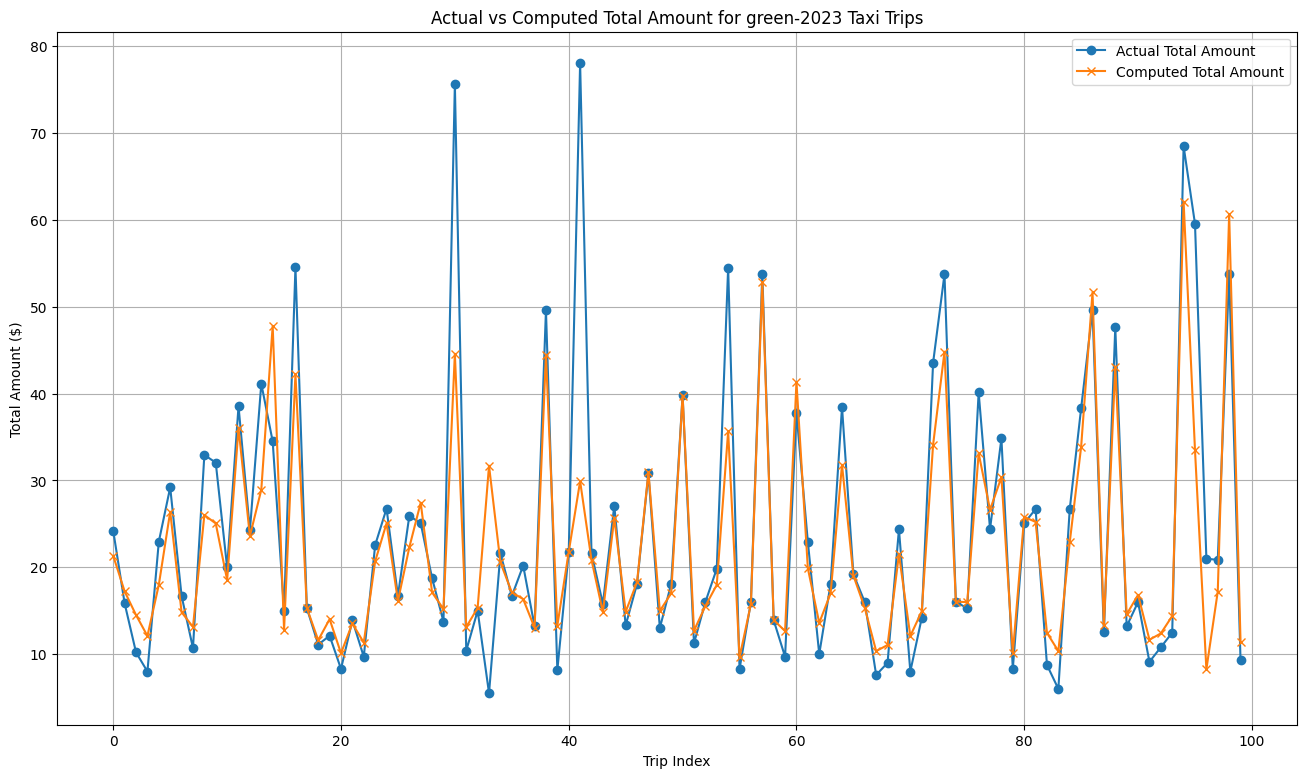

Rate #2 - JFK Airport


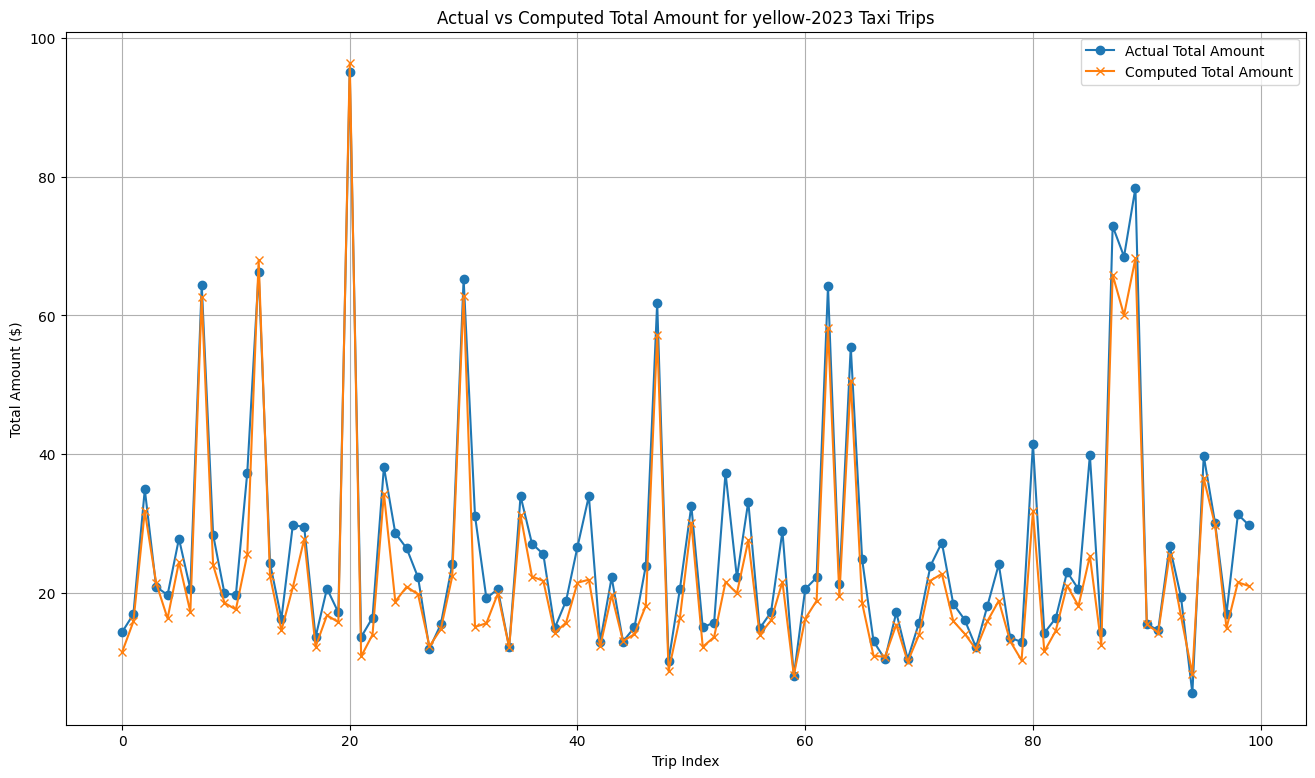

In [31]:
from lib import *

ctables = [
    (GREEN, 2023), 
    (YELLOW, 2023)
]

for (taxi_type, year) in ctables:
    is_green_taxi = True if taxi_type == GREEN else False

    DR.setTable(year, taxi_type)
    table_name = DR.getTableName('uniq_')
    df = getDF(text(f"select * from {table_name} limit 100"))

    df['computed_total_amount'] = df.apply(lambda row: compute_total_amount(row, is_green_taxi), axis=1)

# Plot actual vs computed total amounts
    plt.figure(figsize=(16, 9))
    plt.plot(df.index, df['total_amount'], label='Actual Total Amount', marker='o')
    plt.plot(df.index, df['computed_total_amount'], label='Computed Total Amount', marker='x')

    # Add labels and title
    plt.xlabel('Trip Index')
    plt.ylabel('Total Amount ($)')
    plt.title(f'Actual vs Computed Total Amount for {taxi_type}-{year} Taxi Trips')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


In [34]:
# generate a df with og total_amount and the computed total_amount, and then find the difference between the two data
year = 2023
taxi_type = GREEN
is_green_taxi = True if taxi_type == GREEN else False

DR.setTable(year, taxi_type)
table_name = DR.getTableName('uniq_')
df = getDF(text(f"select * from {table_name}"))

df['computed_total_amount'] = df.apply(lambda row: compute_total_amount(row, is_green_taxi), axis=1)

df['amount_difference'] = df['total_amount'] - df['computed_total_amount']


In [35]:
# Group by location_id and calculate the mean difference
grouped_diff = df.groupby('pu_location_id')['amount_difference'].mean().reset_index()

# Display the grouped differences
O.out(grouped_diff, True)


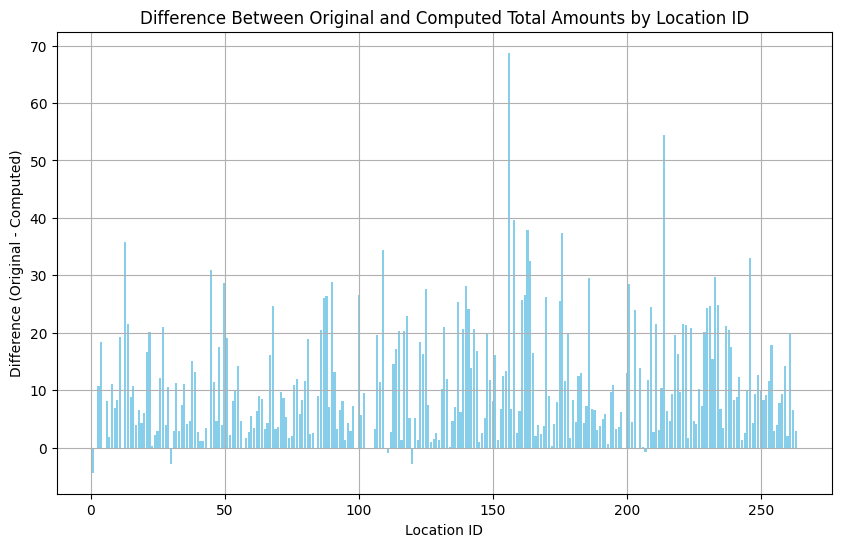

In [36]:
# Plotting the difference between original and computed total amounts by location_id
plt.figure(figsize=(10, 6))
plt.bar(grouped_diff['pu_location_id'], grouped_diff['amount_difference'], color='skyblue')

# Adding labels and title
plt.xlabel('Location ID')
plt.ylabel('Difference (Original - Computed)')
plt.title('Difference Between Original and Computed Total Amounts by Location ID')
plt.grid(True)

# Show the plot
plt.show()


In [17]:
# # Imports and constants
# import pandas as pd
# import matplotlib.pyplot as plt
# from sqlalchemy.sql import text
# from lib import Output, TaxiDBReader, runSql, GREEN, YELLOW, TABLES, tabulate, CHUNK_SIZE, TABLE_FORMAT, SEPARATOR, DR, getDF, COLUMNS, normalizedColumns, ALL_COLUMNS, TAXI_ZONES

# from ts_toolbox import plot_rolling_mean_var, ACF_PACF_Plot

# O = Output('output/ppt2_output.txt') 

# def get_cmap(n, name='hsv'):
#     return plt.cm.get_cmap(name, n)


In [ ]:
# import matplotlib.dates as mdates

# ctables = [
#     (GREEN, 2023), # mar 3
#     # (YELLOW, 2023) # oct 10
# ]

# for t in ctables:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     O.out(f'table: {table_name}')
#     uniq_table_name = DR.getTableName('uniq_')

#     df = getDF(text(f'''
#     WITH t AS (
#         SELECT *, 
#             (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
#             CAST(strftime('%Y', pickup_datetime) as integer) as year
#         FROM {uniq_table_name}
#         WHERE year = {year}
#     )
#     SELECT (strftime('%Y-%m-%d', pickup_datetime)) as dt_hr, 
#            AVG(f_total_amount) as total_amount, 
#            AVG(f_fare_amount) as fare_amount, 
#            AVG(f_trip_distance) as trip_distance,
#            AVG(trip_duration) as trip_duration
#     FROM t
#     WHERE 
#         CAST(strftime('%m', pickup_datetime) as integer)=8 OR
#         CAST(strftime('%m', pickup_datetime) as integer)=9 OR
#         CAST(strftime('%m', pickup_datetime) as integer)=10
#     GROUP BY dt_hr
# '''))

#     df['dt_hr'] = pd.to_datetime(df['dt_hr'])
#     # compare time distribution of variables like passengers, amount and distance of green taxi vs yellow taxi
#     columns = [
#         'total_amount',
#     ]
#     cmap = get_cmap(len(columns) + 1)
#     for i, c in enumerate(columns):
#         fig, ax = plt.subplots()
#         fig.set_figwidth(16)
#         fig.set_figheight(9)
#         ax.plot(df['dt_hr'], df[c], color=cmap(i))
#         # ax.xaxis.set_major_locator(mdates.DayLocator())
#         # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

#         plt.xlabel('Time')
#         plt.ylabel(c)
#         plt.grid(True)
#         plt.title(f'Hourly Sampled AVG {c}')
#         plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split

# DR.setTable(2023, GREEN)
# utable = DR.getTableName('uniq_')
# disptable  = DR.getTableName()

# gdf = getDF(text(f'''
#     WITH t AS (
#         SELECT *, 
#             (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
#             CAST(strftime('%Y', pickup_datetime) as integer) as year
#         FROM {utable}
#         WHERE year = {2023}
#     )
#     SELECT (strftime('%Y-%m-%d %H', pickup_datetime)) as dt_hr, 
#            AVG(f_total_amount) as total_amount, 
#            AVG(f_fare_amount) as fare_amount, 
#            AVG(f_trip_distance) as trip_distance,
#            AVG(trip_duration) as trip_duration
#     FROM t
#     GROUP BY dt_hr
# '''))

# train_gdf, test_gdf = train_test_split(gdf, test_size=0.30)

# print(f'train data shape: {train_gdf.shape}')
# print(f'test data shape: {test_gdf.shape}')


In [ ]:
# # rolling mean and variance
# plot_rolling_mean_var(gdf['total_amount'], '#', 'total amount')

In [ ]:
# # acf and pacf plot
# ACF_PACF_Plot(gdf['total_amount'], 20)

In [2]:
# columns = ['trip_distance', 'fare_amount', 'mta_tax', 'total_amount', 'passenger_count']
# prefix = 'f_'

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     uniq_table_name = DR.getTableName('uniq_')
#     O.out(f'table name: {table_name}')
#     for c in columns:
#         nc = prefix+c
#         res = runSql(text(f'''
#     SELECT COUNT(1) FROM {uniq_table_name} WHERE {nc}<>{c}
# '''))
#         O.out(f'Number of values updated using average method for {c}: {res.scalar()}')
#     O.out(SEPARATOR)


In [4]:

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     uniq_table_name = DR.getTableName('uniq_')
#     O.out(f'table name: {table_name}')
    
#     res = runSql(text(f'''
#     SELECT COUNT(1) FROM {uniq_table_name}
# '''))
#     O.out(f'# of remaining rows after cleaning: {res.scalar()}')

# O.out(SEPARATOR)


In [5]:
# O.out(f'Total # of columns after cleaning: {len(ALL_COLUMNS)}')

In [ ]:
# # Timeseries model application
# from statsmodels.tsa.arima.model import ARIMA
# import matplotlib.pyplot as plt

# # Assuming df_daily['total_amount'] is your target series
# # Split the data into train and test sets

# year = 2023
# DR.setTable(year, taxi_type)
# table_name = DR.getTableName()
# uniq_table_name = DR.getTableName('uniq_')
# O.out(f'table: {table_name}')
# sql = text(f'''
#     WITH t AS (
#         SELECT *, 
#             (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
#             CAST(strftime('%Y', pickup_datetime) as integer) as year
#         FROM {uniq_table_name}
#         WHERE f_trip_distance < 20 AND f_total_amount <= 100
#             AND trip_duration > 0 AND trip_duration <= 7200
#             AND year = {year}
#     )
#     SELECT (strftime('%Y-%m-%d %H', pickup_datetime)) as dt_hr, 
#            AVG(f_total_amount) as total_amount, 
#            AVG(f_fare_amount) as fare_amount, 
#            AVG(f_trip_distance) as trip_distance,
#            AVG(trip_duration) as trip_duration
#     FROM t
#     GROUP BY dt_hr
# ''')

# df_daily = getDF(sql)

# # train = df_daily['total_amount'][:'2023-06']
# # test = df_daily['total_amount']['2023-07':]

# # Fit an ARIMA model (start with default order, and tune it)
# model = ARIMA(train, order=(p,d,q))  # You need to tune (p,d,q)
# model_fit = model.fit()

# # Make predictions
# predictions = model_fit.forecast(steps=len(test))

# # Plot the results
# plt.plot(test.index, test, label='Actual')
# plt.plot(test.index, predictions, label='Forecast')
# plt.legend()
# plt.show()
